In [106]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib notebook

In [90]:
class PertGraph:
    def __init__(self, data):
        self.graph = nx.DiGraph()
        for activity in data.to_records(index=True):
            edge = (activity['nodo_inicial'], activity['nodo_final'] )
            self.graph.add_edge(*edge)
            self.graph.edges[edge]['nombre'] = activity['index']
            self.graph.edges[edge]['duracion'] = activity['duracion']
        self.calcula_pert()
            
    def calcula_pert(self):
        lista_de_nodos = list(self.graph)
        
        # [0] sirve para inicializar el tiempo temprano del nodo inicial correctamente
        # [self.graph.nodes[lista_de_nodos[-1]]['temprano']] sirve para inicializar el tiempo tardío del nodo final correctamente con el valor del tiempo temprano
        
        for nodo in lista_de_nodos:
           self.graph.nodes[nodo]['temprano'] = max([0]+
                                                    [(self.graph.nodes[inicial]['temprano'] + attributes['duracion']) 
                                                          for (inicial, final, attributes) in self.graph.in_edges(nodo, data=True) ] )
        for nodo in lista_de_nodos[::-1]:
           self.graph.nodes[nodo]['tardio'] = min([self.graph.nodes[lista_de_nodos[-1]]['temprano']]+
                                                  [ (self.graph.nodes[final]['tardio'] - attributes['duracion'])
                                                    for (inicial, final, attributes) in self.graph.out_edges(nodo, data=True) ] )
        
        for (nodo_inicial, nodo_final) in self.graph.edges:
            self.graph.edges[nodo_inicial, nodo_final]['H_total'] = self.graph.nodes[nodo_final]['tardio'] - self.graph.edges[nodo_inicial, nodo_final]['duracion'] - self.graph.nodes[nodo_inicial]['temprano']

    def duracion(self):
        return  nx.dag_longest_path_length(self.graph, weight='duracion') 
    
    def camino_critico(self):
        return {'Actividades': [(attributes['nombre']) for (nodo_inicial, nodo_final, attributes) in pert.graph.edges(data=True) if attributes['H_total']==0],
                'Nodos': nx.dag_longest_path(self.graph, weight='duracion')}
    
    def tiempos(self):
        return pd.DataFrame(dict(pert.graph.nodes(data=True)))
    
    def holguras(self):
        holguras = pd.DataFrame([{'H_total': attributes['H_total'], 'nombre': attributes['nombre']}
                                             for (inicial, final, attributes) in self.graph.edges(data=True)]).set_index('nombre')
        return holguras
    def draw(self):
        nx.draw(self.graph,with_labels=True)


In [91]:
datos_pert = pd.DataFrame({ 'A':  (1, 2, 3),
                            'B':  (1, 3, 2),
                            'C':  (2, 3, 7),
                            'D':  (2, 4, 5),
                            'E':  (3, 5, 6),
                            'F':  (3, 6, 7),
                            'G':  (4, 5, 4),
                            'H':  (5, 6, 4),
                            'f1': (1, 5, 0),
                            'f2': (2, 5, 0),
                          },
                          index=['nodo_inicial','nodo_final','duracion']).T

In [92]:
pert = PertGraph(datos_pert)

pert.tiempos()

,1,2,3,4,5,6
tardio,0,3,10,12,16,20
temprano,0,3,10,8,16,20


In [93]:
pert.duracion()

20

In [94]:
pert.camino_critico()

{'Actividades': ['A', 'C', 'E', 'H'], 'Nodos': [1, 2, 3, 5, 6]}

In [100]:
pert.holguras()

,H_total
nombre,
A,0
B,8
f1,16
C,0
D,4
f2,13
E,0
F,3
G,4


In [99]:
pert.holguras().query('H_total == 0')

,H_total
nombre,
A,0
C,0
E,0
H,0


In [96]:
pd.DataFrame( data=nx.adjacency_matrix(pert.graph, weight='duracion').todense(),
              index=  pert.graph.nodes(),
              columns= pert.graph.nodes()
            )

,1,2,3,4,5,6
1,0,3,2,0,0,0
2,0,0,7,5,0,0
3,0,0,0,0,6,7
4,0,0,0,0,4,0
5,0,0,0,0,0,4
6,0,0,0,0,0,0


In [97]:
[(attributes['nombre']) for (nodo_inicial, nodo_final, attributes) in pert.graph.edges(data=True) if attributes['H_total']==0]

['A', 'C', 'E', 'H']

<IPython.core.display.Javascript object>


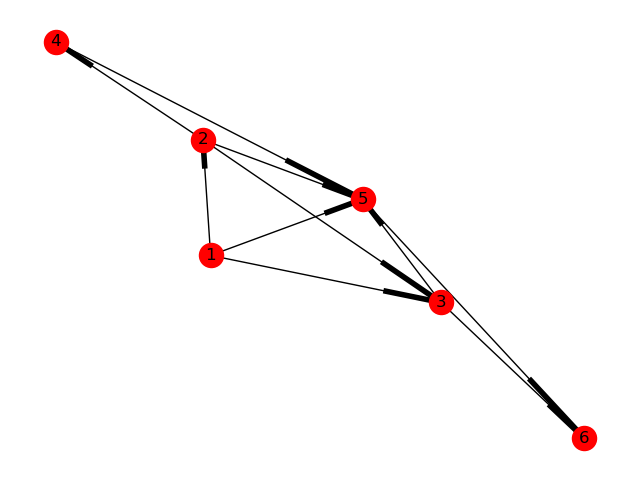

In [98]:
pert.draw()


In [103]:
nx.nx_agraph.to_agraph(pert.graph)

ImportError: ('requires pygraphviz ', 'http://pygraphviz.github.io/')